<a href="https://colab.research.google.com/github/nupur1262/ImageCaptioning/blob/main/Image_Captioning_Project_CE42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Kaggle.json file

In [ ]:
from google.colab import files  
my_file=files.upload()

Saving kaggle.json to kaggle.json


Importing required libraries

In [ ]:
!pip install ipython
!pip install gTTs
!pip install librosa
import librosa
import gtts
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras import utils as np_utils
import cv2
import matplotlib.pyplot as plt
import collections
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Setting environment variables

In [ ]:
import warnings
import os
import pandas as pd
import warnings
cred = pd.read_json("kaggle.json",lines=True)
os.environ['KAGGLE_USERNAME'] = cred.iloc[0][0]
os.environ['KAGGLE_KEY'] = cred.iloc[0][1]
warnings.filterwarnings("ignore")

Downloading flickr8k Dataset from kaggle

In [ ]:
!kaggle datasets download -d nupurpahuja09/mydataset

In [ ]:
!unzip "mydataset.zip"

In [ ]:
#Creating a function to read the text in the Captions File

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions




captions  = readTextFile("/content/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
first,second  = captions[0].split('\t')





#we are creating a dictionary in which for each image we are storing a list of all its captions
#Creating a Dictionary
descriptions = {}





#For each element in the list -> captions
for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)








#Cleaning the text , i.e. , removing unwanted characters from the caption string
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence







#Cleaning all the captions
#cleaing all the caption
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])








#Creating a text file so as to store the dictionary -> descriptions in the file

with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))






#Creating a set containing all the words corresponding to all the words in the captions of all the images in the dataset
# Vocab

vocab = set()





#taking key of the dictionary -> descriptions
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]





#Storing all the words in a list
# Total No of words across all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]





#Creating a Dictionary using Counter() function to store the frequency of each word
counter = collections.Counter(total_words)
freq_cnt = dict(counter)






#Sort this dictionary according to the freq count Also cleaning the dictionary so as to keep only those words with frequency greater than a threshold
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])





# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]






#Now let's create proper dataset for training and testing of our Model
#These files contains the name of images for training and testing
train_file_data = readTextFile("/content/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/Flickr8k_text/Flickr_8k.testImages.txt")
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]





#Prepare Description for the Training Data

#Tweak - Add 's' and 'e' token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

#Creating Model

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
#Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model2 = Model(model.input, model.layers[-2].output)


def preprocess_img(i):
  img=cv2.imread(i)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img , (224,224))
  img = img.reshape(1,224,224,3)
  return img
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model2.predict(img).reshape(2048,)
    return feature_vector

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
IMG_PATH='/content/flickr8k_dataset/Flicker8k_Dataset/'
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

In [ ]:

# Store everything to the disk 
with open("/content/drive/MyDrive/Img_Cap1/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)


start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)



with open("/content/drive/MyDrive/Img_Cap1/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_to_read = open("/content/drive/MyDrive/Img_Cap1/encoded_train_features.pkl", "rb")

encoding_train = pickle.load(file_to_read)

file_to_read2 = open("/content/drive/MyDrive/Img_Cap1/encoded_test_features.pkl", "rb")
encoding_test={}
encoding_test = pickle.load(file_to_read2)

In [ ]:
#Creating a dict in which for each image , it's feature vector is stored
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word



# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1


#import itertools
#train_descriptions = dict(itertools.islice(train_descriptions.items(), 3000))
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))


def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
        return X1,X2,y

In [ ]:
!kaggle datasets download -d nupurpahuja09/gloved
!unzip "/content/gloved.zip"

 84% 57.0M/67.7M [00:00<00:00, 68.1MB/s]
100% 67.7M/67.7M [00:00<00:00, 99.0MB/s]
Archive:  /content/gloved.zip
  inflating: glove.6B.50d (1).txt    


In [ ]:
embedding_index = {}
f= open('/content/glove.6B.50d (1).txt','r+')
for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.asarray(values[1:],dtype='float')
    embedding_index[word] = word_embedding
f.close()







def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
embedding_matrix = get_embedding_matrix()










input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)
#Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size, output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.5)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
d1=Dropout(0.5)(decoder1)
decoder3=Dense(256,activation='relu')(d1)
d2=Dropout(0.5)(decoder3)
outputs = Dense(vocab_size,activation='softmax')(d2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)


# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy',optimizer="adam")


epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
def train():
    
    for i in range(1):
        X, y_in, y_out = data_generator(train_descriptions11,encoding_train,word_to_idx,max_len,6)
        X = np.array(X)
        y_in = np.array(y_in, dtype='float64')
        y_out = np.array(y_out, dtype='float64')
        model.fit([X, y_in], y_out)
        model.save('/content/drive/MyDrive/Img_Cap1/Model/model_' + str(i)+ '.h5')


train()

In [ ]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
train()

9214/9214 [==============================] - 1282s 139ms/step - loss: 4.1991


In [ ]:
train()

9214/9214 [==============================] - 1312s 142ms/step - loss: 4.1370


In [ ]:
train()

9214/9214 [==============================] - 1317s 143ms/step - loss: 4.0948


In [ ]:
train()

9214/9214 [==============================] - 1291s 140ms/step - loss: 4.0578


In [ ]:
train()

9214/9214 [==============================] - 1297s 141ms/step - loss: 4.0303


In [ ]:
#modelx = load_model('/content/drive/MyDrive/Img_Cap1/Model/model_0.h5')

def predict_caption(photo,n):
    img=photo

    #img = cv2.imread(img)
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        if(n==1):
          modelx=load_model('/content/drive/MyDrive/Img_Cap1/Model/model_11.h5')
        elif(n==2):
          modelx=load_model('/content/drive/MyDrive/Img_Cap1/Model/model_16.h5')
        elif(n==3):
          modelx=load_model('/content/drive/MyDrive/Img_Cap1/Model/model_14.h5')
        elif(n==4):
          modelx=load_model('/content/drive/MyDrive/Img_Cap1/Model/model_10.h5')
        elif(n==5):
          modelx=load_model('/content/drive/MyDrive/Img_Cap1/Model/model_11.h5')
        ypred = modelx.predict([img,sequence],verbose=0)
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
i='/content/flickr8k_dataset/Flicker8k_Dataset/2513260012_03d33305cf.jpg'
img=cv2.imread(i)

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img , (224,224))

img = img.reshape(1,224,224,3)
pred=model2.predict(img)


caption = predict_caption(pred)
x = plt.imread(i)
plt.axis('off')
plt.imshow(x)
plt.show()

print(caption)
tts = gtts.gTTS(caption , lang='en')
tts.save("caption.mp3")
ip.display.Audio('/content/caption.mp3')
#sleep(3)

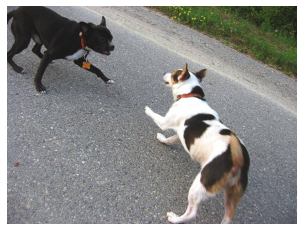

two people are playing in the snow


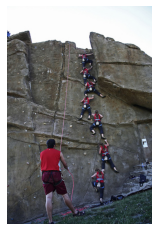

man in red shirt is standing on the air


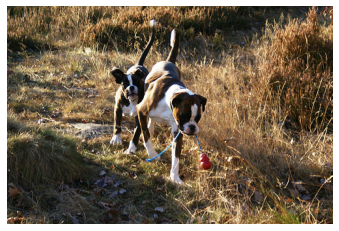

two dogs are running in the grass


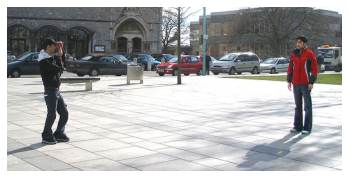

man in red shirt is standing on the street


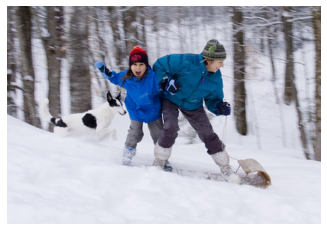

two people are playing in the snow


In [ ]:
pix=['1001773457_577c3a7d70.jpg' , '1016887272_03199f49c4.jpg' , '2171891283_dedd9cf416.jpg' , '1213336750_2269b51397.jpg' , '2141713971_e25eb12712.jpg']
n=1

for image in pix:
  i='/content/flickr8k_dataset/Flicker8k_Dataset/'+image
  img=cv2.imread(i)
  
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img , (224,224))

  img = img.reshape(1,224,224,3)
  pred=model2.predict(img)


  caption = predict_caption(pred,n)
  n+=1
  x = plt.imread(i)
  plt.axis('off')
  plt.imshow(x)
  plt.show()

  print(caption)
  #tts = gtts.gTTS(caption , lang='en')
  #tts.save("caption"+ str(n) +".mp3")
  #ip.display.Audio('/content/caption.mp3')
  #sleep(3)